In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
def ohe_the_df(dataframe):
    
    num_feats = ['beds', 'sq_footage', 'year_built',
                   'has_address_2', 'baths_incl_half', 'walk_score']
    cat_feats = ['city', 'parking_spots', 'clean_mls_types', 'laundry_type']

    num_feats_df = dataframe[num_feats]
    cat_feats_df = dataframe[cat_feats]
    
    ohe_X = ohe.transform(cat_feats_df)
    feature_labels = ohe.get_feature_names(cat_feats)
    cat_feats_ohe = pd.DataFrame(data = ohe_X, 
                                 columns=feature_labels,
                                index = num_feats_df.index)
    combined_dataframe = pd.concat([num_feats_df, cat_feats_ohe], axis = 1)
    return combined_dataframe

def get_cv_r2s_test(model, X, y):
    cv_r2s = cross_val_score(model, X, y, cv=5, scoring = 'r2')
    mean_r2 = np.mean(cv_r2s)
    return mean_r2

def get_cv_r2s(model, X, y):
    cv_r2s = cross_val_score(model, X, y, cv=5, scoring = 'r2')
    print('Scores: ', cv_r2s, '\n')
    print(f'Simple mean cv r^2: {np.mean(cv_r2s):.3f} +- {np.std(cv_r2s):.3f}')

In [12]:
with open('pickles/cleaned_210115_data_laundry_revised_add_ws.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 0 to 1692
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             1209 non-null   string 
 1   zip              1209 non-null   string 
 2   neighborhood     1209 non-null   string 
 3   address_1        1209 non-null   string 
 4   address_2        1209 non-null   string 
 5   price            1209 non-null   float64
 6   beds             1209 non-null   float64
 7   baths            1209 non-null   float64
 8   half_baths       1209 non-null   float64
 9   sq_footage       1209 non-null   int64  
 10  mls_num          1209 non-null   string 
 11  furnished        1209 non-null   string 
 12  mls_type         1209 non-null   string 
 13  year_built       1209 non-null   float64
 14  county           1200 non-null   string 
 15  laundry_type     1209 non-null   object 
 16  laundry_snippet  1209 non-null   object 
 17  parking_spots 

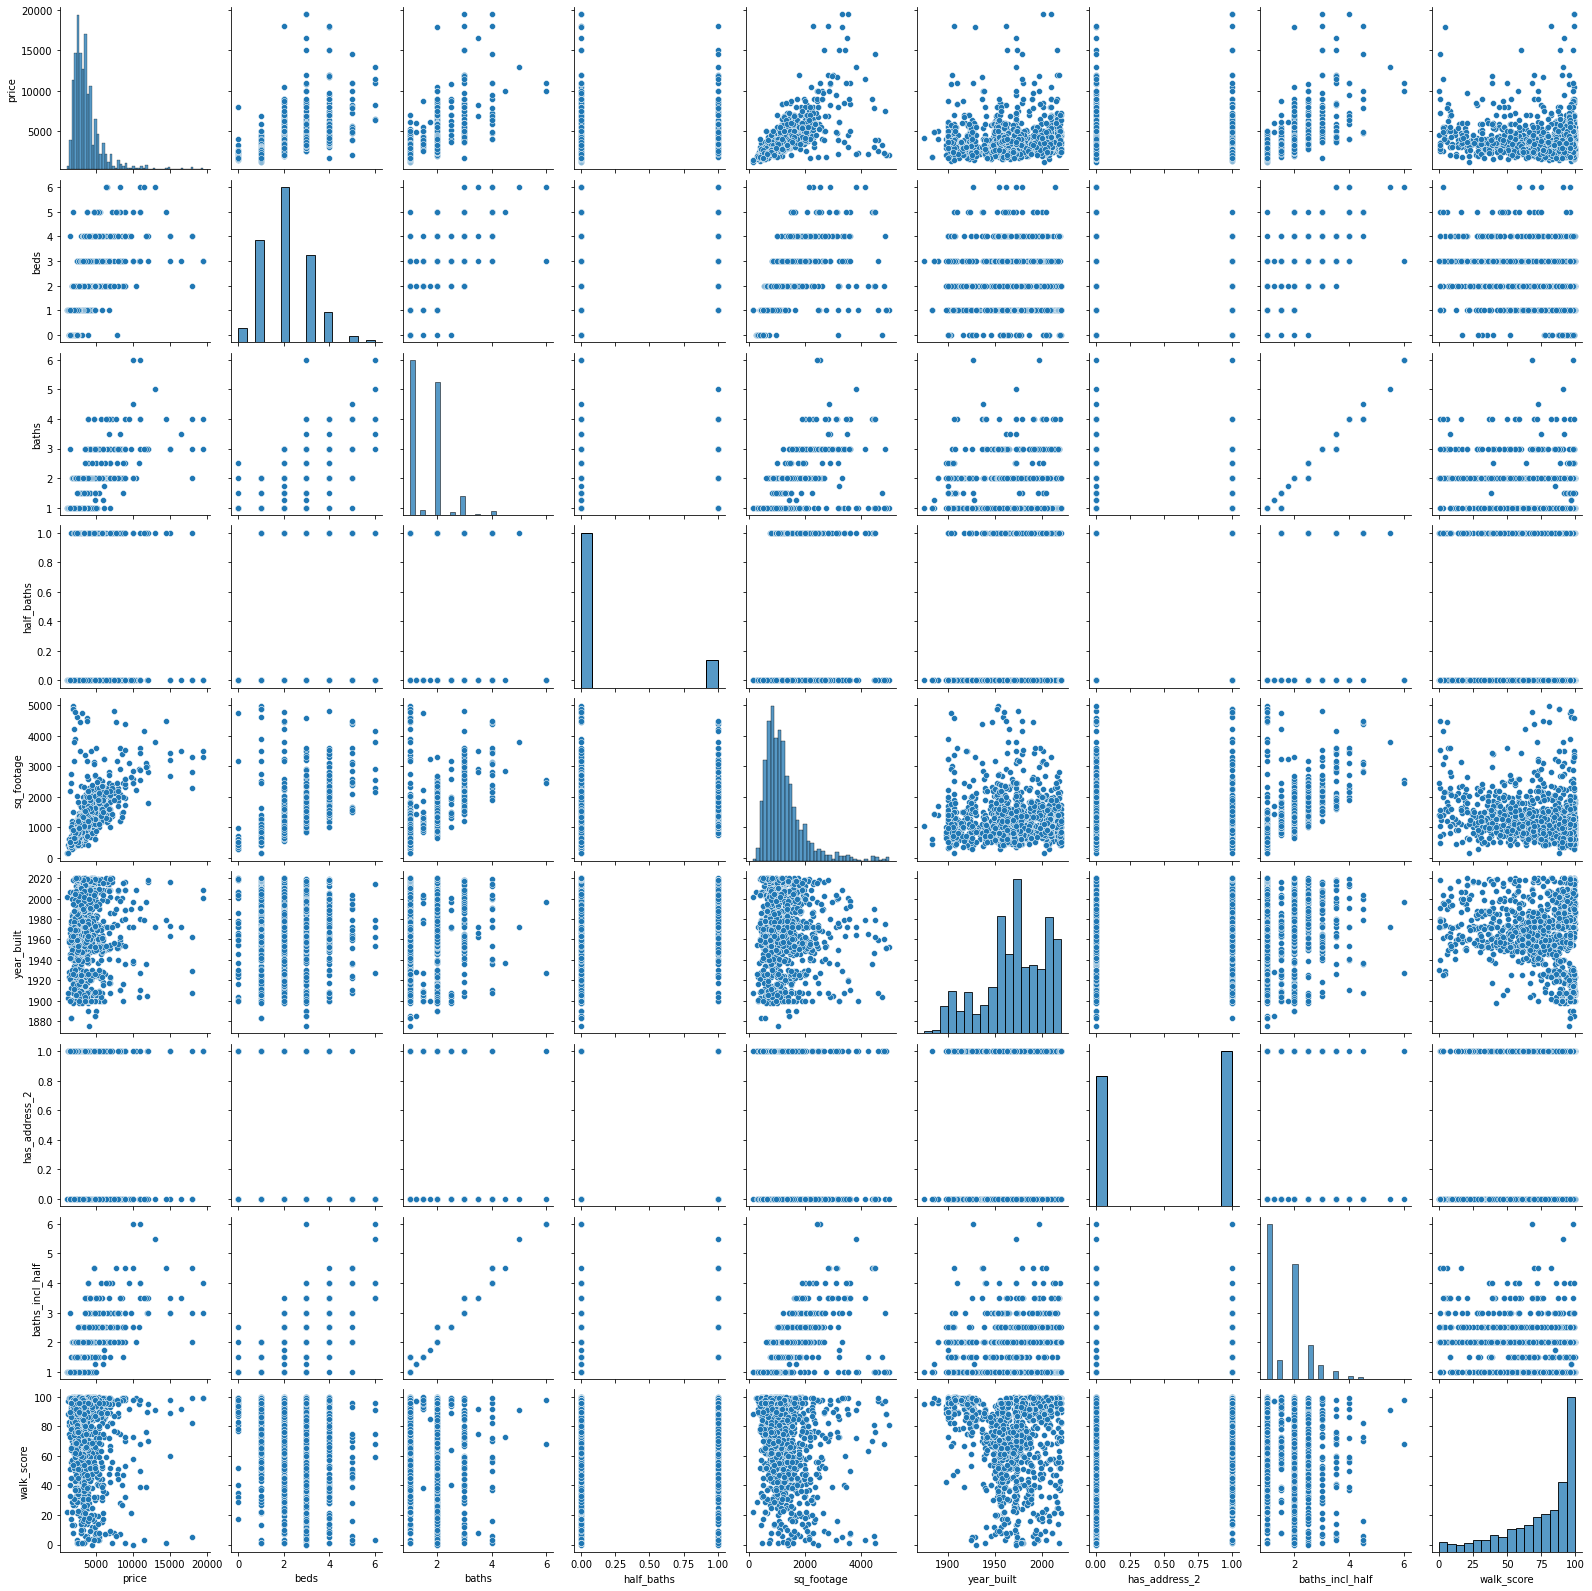

In [5]:
sns.pairplot(df);

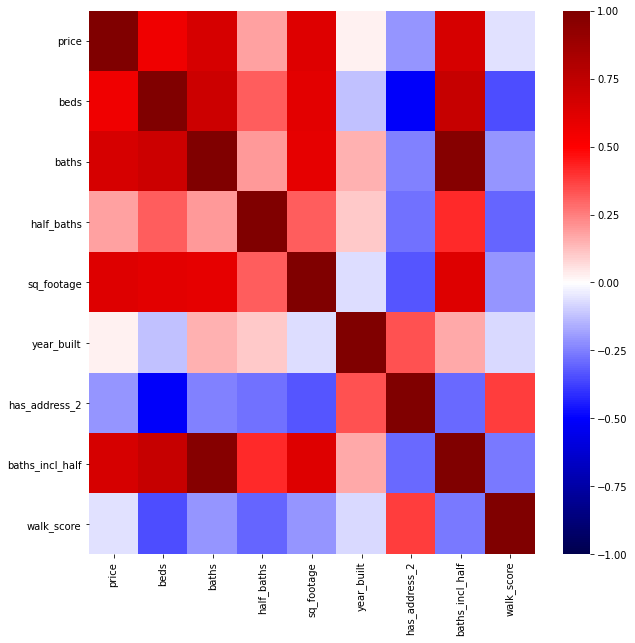

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

---
---

**Model Constraint: based on the analysis below, rental units must be under 3100* sq. feet to be evaluated using this model**

---
---

The ideal square footage cutoff was evaluated below by testing a series of subsets of the original df against a basic linear regression using only numerical features. The original method used the R^2 of all training data and the revised method uses the 5-fold CV mean R^2. Both methods give the same result of 3100 sq. feet as the ideal maximum, although the pattern is less obvious using the revised method.

---

In [7]:
sq_max_ls = []
score_ls = []
df_len = []
max_score = [0, 0]
for sq_max in range(1000, 6000, 300):  
    sq_max_ls.append(sq_max)
    df_sq = df[df.sq_footage < sq_max]
    
    X = df_sq[['beds', 'sq_footage', 'year_built',
                   'has_address_2', 'baths_incl_half', 'walk_score']]
    y = df_sq['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    score = lr.score(X_train, y_train)
    score_ls.append(score)
    df_len.append(df_sq.shape[0])
    if score > max_score[0]:
        max_score = [score, sq_max]
print('max_score: ', max_score[0], '\nfilter: df[df.sq_footage <', max_score[1],']')

max_score:  0.5833056426295828 
filter: df[df.sq_footage < 3100 ]


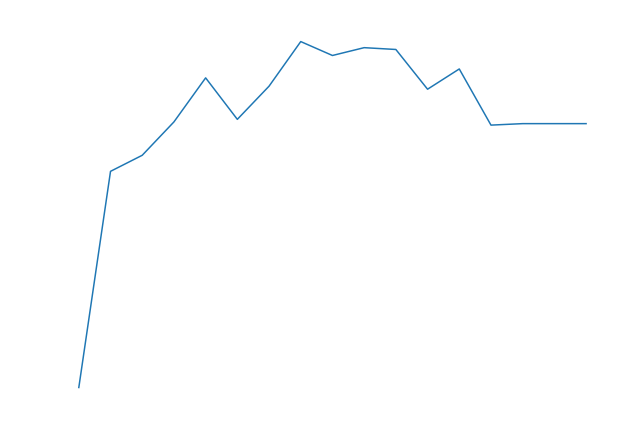

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
g = sns.lineplot(x = sq_max_ls, y = score_ls);

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')

plt.title('R^2 for Range of Square Footage Maximum Values', fontsize = 15);
plt.xlabel('Max Square Footage Included in Training Dataset', fontsize = 12);
plt.ylabel('R^2', fontsize = 12);
g.figure.savefig('squareft.png')

In [9]:
sq_max_ls = []
score_ls = []
df_len = []
max_score = [0, 0]
for sq_max in range(1000, 6000, 300):  
    sq_max_ls.append(sq_max)
    df_sq = df[df.sq_footage < sq_max]
    
    # use numerical features only
    X = df_sq[['beds', 'sq_footage', 'year_built',
                   'has_address_2', 'baths_incl_half', 'walk_score']]
    y = df_sq['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)
    
    lr = LinearRegression()
    score = get_cv_r2s_test(lr, X_train, y_train)
    
    score_ls.append(score)
    
    df_len.append(df_sq.shape[0])
    if score > max_score[0]:
        max_score = [score, sq_max]
        
print('max_score: ', max_score[0], '\nfilter: df[df.sq_footage <', max_score[1],']')

max_score:  0.5542189542139206 
filter: df[df.sq_footage < 3100 ]


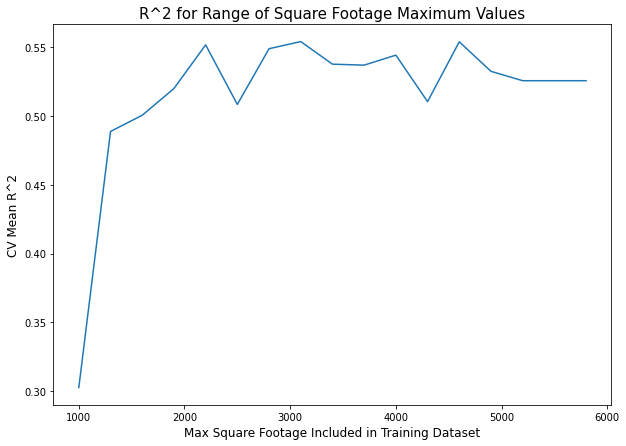

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
g = sns.lineplot(x = sq_max_ls, y = score_ls);

plt.title('R^2 for Range of Square Footage Maximum Values', fontsize = 15);
plt.xlabel('Max Square Footage Included in Training Dataset', fontsize = 12);
plt.ylabel('CV Mean R^2', fontsize = 12);
g.figure.savefig('squareft.png')

In [13]:
dp_before = df.shape[0]
df = df[df.sq_footage <= 3100].reset_index()
dp_after = df.shape[0]
print(dp_before - dp_after, 'datapoints dropped')

40 datapoints dropped


In [14]:
X_all = df[['city',
       'beds', 'sq_footage', 'year_built', 'laundry_type',
       'parking_spots', 'has_address_2', 'baths_incl_half',
       'clean_mls_types', 'walk_score']]

y_all = df['price']

# train/test split
X, X_test, y, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 25)

In [15]:
# fit the ohe

num_feats = ['beds', 'sq_footage', 'year_built',
                   'has_address_2', 'baths_incl_half', 'walk_score']
cat_feats = ['city', 'parking_spots', 'clean_mls_types', 'laundry_type']

num_feats_df = X[num_feats]
cat_feats_df = X[cat_feats]

ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
ohe.fit(cat_feats_df)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

---

**model 1: simple linear regression**
    
---

In [16]:
def m1_premod(X):  
    X_ohe = ohe_the_df(X)
    return X_ohe

lr_m1 = LinearRegression()

print(get_cv_r2s(lr_m1, m1_premod(X), y))

lr_m1.fit(m1_premod(X), y)

Scores:  [0.66712646 0.69126022 0.5841167  0.60933754 0.63753337] 

Simple mean cv r^2: 0.638 +- 0.038
None


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

**model 2: feature engineering v1**

---

In [17]:
def m2_premod(X):    
    X_ohe = ohe_the_df(X)
    X_eng = X_ohe.copy()
    
    X_eng['walk_score_sq_footage'] = X_ohe['walk_score']*X_ohe['sq_footage']
    X_eng['walk_score_year_built'] = X_ohe['walk_score']*X_ohe['year_built']
    X_eng['mls_type_year_built'] = X_ohe['clean_mls_types_house']*X_ohe['year_built']
    X_eng['beds_baths'] = X_ohe['beds']*X_ohe['baths_incl_half']
    
    return X_eng

lr_m2 = LinearRegression()

print(get_cv_r2s(lr_m2, m2_premod(X), y))

lr_m2.fit(m2_premod(X), y)

Scores:  [0.66286909 0.72460829 0.59961024 0.62995196 0.66705125] 

Simple mean cv r^2: 0.657 +- 0.042
None


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

**model 3: feature engineering v2**
    
---

In [18]:
def m3_premod(X):
    X_ohe = ohe_the_df(X)
    X_eng = X_ohe.copy()
    
    X_eng['walk_score_sq_footage'] = X_ohe['walk_score']*X_ohe['sq_footage']
    X_eng['walk_score_year_built'] = X_ohe['walk_score']*X_ohe['year_built']
    X_eng['mls_type_year_built'] = X_ohe['clean_mls_types_house']*X_ohe['year_built']
    X_eng['beds_baths'] = X_ohe['beds']*X_ohe['baths_incl_half']
    
    X_eng['beds_walk_score'] = X_ohe['walk_score']*X_ohe['beds']
    X_eng['address_2_walk_score'] = X_ohe['walk_score']*X_ohe['has_address_2']
    X_eng['year_built_address_2'] = X_ohe['year_built']*X_ohe['has_address_2']
    
    return X_eng

lr_m3 = LinearRegression()

print(get_cv_r2s(lr_m3, m3_premod(X), y))

lr_m3.fit(m3_premod(X), y)

Scores:  [0.65954506 0.72316851 0.60717657 0.65136845 0.67807882] 

Simple mean cv r^2: 0.664 +- 0.038
None


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

**model 4: feature engineering v3**

---

In [19]:
def m4_premod(X):
    X_ohe = ohe_the_df(X)
    X_eng = X_ohe.copy()
    
    X_eng['walk_score_sq_footage'] = X_ohe['walk_score']*X_ohe['sq_footage']
    X_eng['walk_score_year_built'] = X_ohe['walk_score']*X_ohe['year_built']
    X_eng['mls_type_year_built'] = X_ohe['clean_mls_types_house']*X_ohe['year_built']
    X_eng['beds_baths'] = X_ohe['beds']*X_ohe['baths_incl_half']
    
    X_eng['beds_walk_score'] = X_ohe['walk_score']*X_ohe['beds']
    X_eng['address_2_walk_score'] = X_ohe['walk_score']*X_ohe['has_address_2']
    X_eng['year_built_address_2'] = X_ohe['year_built']*X_ohe['has_address_2']
    
    X_eng['walk_score_walk_score'] = X_ohe['walk_score']**3
    
    '''
    the below features were tested, but reduced the R^2
    '''
    # X_eng['walk_score_walk_score'] = X_ohe['walk_score']**2
    # X_eng['beds_beds_beds'] = X_ohe['beds']**3
    # X_eng['beds_beds_beds'] = X_ohe['beds']**3
    
    
    
    return X_eng

lr_m4 = LinearRegression()
    
print(get_cv_r2s(lr_m4, m4_premod(X), y))

lr_m4.fit(m4_premod(X), y)

Scores:  [0.66133568 0.7263213  0.60932311 0.64955064 0.67502474] 

Simple mean cv r^2: 0.664 +- 0.038
None


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

**model 5: consolidate mls_types**

---

In [20]:
def m5_premod(X):
    '''
    consolidate some of the mls_type columns with the hope of making fewer,  
    but stronger mls_type features
    '''
    X_ohe = ohe_the_df(X)
    X_eng = X_ohe.copy()
    
    X_eng['walk_score_sq_footage'] = X_ohe['walk_score']*X_ohe['sq_footage']
    X_eng['walk_score_year_built'] = X_ohe['walk_score']*X_ohe['year_built']
    X_eng['mls_type_year_built'] = X_ohe['clean_mls_types_house']*X_ohe['year_built']
    X_eng['beds_baths'] = X_ohe['beds']*X_ohe['baths_incl_half']
    
    X_eng['beds_walk_score'] = X_ohe['walk_score']*X_ohe['beds']
    X_eng['address_2_walk_score'] = X_ohe['walk_score']*X_ohe['has_address_2']
    X_eng['year_built_address_2'] = X_ohe['year_built']*X_ohe['has_address_2']
    
    X_eng['walk_score_walk_score'] = X_ohe['walk_score']**3
    
    ''''''
    
    X_eng['clean_mls_types_house'] = X_ohe['clean_mls_types_house']
    + X_ohe['clean_mls_types_single-family']
    X_eng['clean_mls_types_condo'] = X_ohe['clean_mls_types_condo']
    + X_ohe['clean_mls_types_duplex'] + X_ohe['clean_mls_types_townhouse']
    X_eng['clean_mls_types_other'] = X_ohe['clean_mls_types_other'] 
    + X_ohe['clean_mls_types_other rental property']
    
    X_eng = X_eng.drop(['clean_mls_types_single-family',
                        'clean_mls_types_duplex',
                        'clean_mls_types_townhouse',
                        'clean_mls_types_other rental property'
                       ], axis = 1)
    
    return X_eng

lr_m5 = LinearRegression()

print(get_cv_r2s(lr_m5, m5_premod(X), y))

lr_m5.fit(m5_premod(X), y)

Scores:  [0.66633396 0.72537886 0.60855783 0.65733205 0.67192336] 

Simple mean cv r^2: 0.666 +- 0.037
None


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

checking residual plot...

---

In [22]:
X_train_res = m5_premod(X).copy()
X_train_res['price'] = y

In [24]:
X_train_res['res'] = lr_m5.predict(X_train_res[X_train_res.columns[:-1]])\
-X_train_res['price']

In [28]:
X_train_res = X_train_res.sort_values(['res'])
X_train_res.head(10)
subset_res = X_train_res[['beds', 'sq_footage', 'year_built', 'has_address_2',
       'baths_incl_half', 'walk_score',
       'parking_spots_parking', 'parking_spots_parking_unknown',
       'clean_mls_types_condo', 'clean_mls_types_detached',
       'clean_mls_types_other', 'price', 'res']]

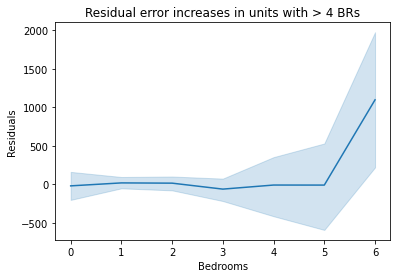

In [29]:
g = sns.lineplot(data = subset_res, x = 'beds', y = 'res');
plt.title('Residual error increases in units with > 4 BRs');
plt.xlabel('Bedrooms');
plt.ylabel('Residuals');

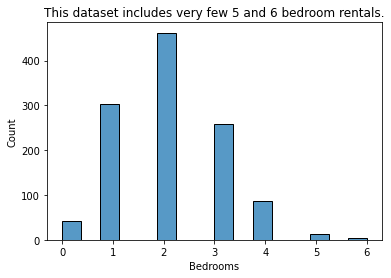

In [30]:
sns.histplot(data = df, x = 'beds');
plt.title('This dataset includes very few 5 and 6 bedroom rentals.');
plt.xlabel('Bedrooms');

---

**model 6: create a 'more than 3 BR' feature**

---

In [31]:
def m6_premod(X):
    '''
    consolidate some of the mls_type columns with the hope of making fewer,  
    but stronger mls_type features
    '''
    X_ohe = ohe_the_df(X)
    X_eng = X_ohe.copy()
    
    X_eng['walk_score_sq_footage'] = X_ohe['walk_score']*X_ohe['sq_footage']
    X_eng['walk_score_year_built'] = X_ohe['walk_score']*X_ohe['year_built']
    X_eng['mls_type_year_built'] = X_ohe['clean_mls_types_house']*X_ohe['year_built']
    X_eng['beds_baths'] = X_ohe['beds']*X_ohe['baths_incl_half']
    
    X_eng['beds_walk_score'] = X_ohe['walk_score']*X_ohe['beds']
    X_eng['address_2_walk_score'] = X_ohe['walk_score']*X_ohe['has_address_2']
    X_eng['year_built_address_2'] = X_ohe['year_built']*X_ohe['has_address_2']
    
    X_eng['walk_score_walk_score'] = X_ohe['walk_score']**3
    
    ''''''
    
    X_eng['clean_mls_types_house'] = X_ohe['clean_mls_types_house']
    + X_ohe['clean_mls_types_single-family']
    X_eng['clean_mls_types_condo'] = X_ohe['clean_mls_types_condo']
    + X_ohe['clean_mls_types_duplex'] + X_ohe['clean_mls_types_townhouse']
    X_eng['clean_mls_types_other'] = X_ohe['clean_mls_types_other'] 
    + X_ohe['clean_mls_types_other rental property']
    
    X_eng = X_eng.drop(['clean_mls_types_single-family',
                        'clean_mls_types_duplex',
                        'clean_mls_types_townhouse',
                        'clean_mls_types_other rental property'
                       ], axis = 1)
    
    X_eng['more_than_3_brs'] = [1 if i > 3 else 0 for i in X_eng.beds]
    X_eng['beds_more_than_3'] = X_eng['sq_footage'] * X_eng['more_than_3_brs']
    
    
    return X_eng

lr_m6 = LinearRegression()

print(get_cv_r2s(lr_m6, m6_premod(X), y))

lr_m6.fit(m6_premod(X), y)

Scores:  [0.65559306 0.72945287 0.60665685 0.67217756 0.68718795] 

Simple mean cv r^2: 0.670 +- 0.040
None


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

**model 7: use model 6's preprocessing, but use lassoCV instead**

---

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [34]:
m7_X_tr = m6_premod(X)

In [35]:
s_m7 = StandardScaler()
s_m7.fit(m7_X_tr.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
m7_X_tr = s_m7.transform(m7_X_tr.values)
m7_X_te = s_m7.transform(m6_premod(X_test).values)

In [37]:
alphavec = 10**np.linspace(-2,2,200)

ridge_m7 = RidgeCV(alphas = alphavec, cv=5)
ridge_m7.fit(m7_X_tr, y)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [38]:
ridge_m7.alpha_

0.027682866303920667

In [39]:
predicted_y_values = ridge_m7.predict(m7_X_te)

print('rmse: ', np.sqrt(mean_squared_error(y_test, predicted_y_values)))
print('r2: ', r2_score(y_test, predicted_y_values))

rmse:  967.2890754774877
r2:  0.6971103229186943
